<a href="https://colab.research.google.com/github/21Ovi/TensorFlow_/blob/main/05_Transfer_Learning_in_TensorFlow_03_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling-Up (Food Vision mini)

We've seen the power of transfer learning `Feature Extraction` and  `Fine-Funing`, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the orignal Food101 paper with 10% of the training (leveraging the power of deep learning)

Orignal Food101 paper : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our base line to beat is 50.76% accuracy across 101 classes

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Sun Jun  4 16:50:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.


In [2]:
!wget https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py

--2023-06-04 16:50:55--  https://raw.githubusercontent.com/21Ovi/Helper-Functions/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10116 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.88K  --.-KB/s    in 0s      

2023-06-04 16:50:55 (85.2 MB/s) - ‘helper_functions.py’ saved [10116/10116]



In [3]:
# Import series of helper functions for our notebooks
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the orignal Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the orignal Food101 dataset but has been preprocessed using the image_adta_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2023-06-04 16:50:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  24.2MB/s    in 68s     

2023-06-04 16:52:07 (22.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How manu images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baby_back_ribs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 director

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False) # Don't shuffle for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 foor class

Here are the steps we're going to take :
* Create a ModelCheckpoint callback
* Craete a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNEtB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 rpochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_1-_percent_data_model_checkpoint"
checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          save_weights_only=True,
                                                          monitor="val_accuracy",
                                                          save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Seetup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # Rescale imputs of image to between 0 & 1, required for model like ResNet50
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name = "input_layer")
x = data_augmentation(inputs) # augments images (only happens during training phase)
x = base_model(x, training = False) # put the base model in inference mode so weights which needs to stay forzen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [10]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_class_10_percent = model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[checkpoint_callbacks])

Epoch 1/5
237/237 [==============================] - 112s 404ms/step - loss: 3.3659 - accuracy: 0.2760 - val_loss: 2.4230 - val_accuracy: 0.4854
Epoch 2/5
237/237 [==============================] - 74s 308ms/step - loss: 2.1900 - accuracy: 0.4994 - val_loss: 1.9727 - val_accuracy: 0.5289
Epoch 3/5
237/237 [==============================] - 71s 299ms/step - loss: 1.8121 - accuracy: 0.5657 - val_loss: 1.7916 - val_accuracy: 0.5490
Epoch 4/5
237/237 [==============================] - 64s 269ms/step - loss: 1.5993 - accuracy: 0.6170 - val_loss: 1.7613 - val_accuracy: 0.5445
Epoch 5/5
237/237 [==============================] - 54s 225ms/step - loss: 1.4584 - accuracy: 0.6397 - val_loss: 1.7296 - val_accuracy: 0.5461


In [12]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 59s 75ms/step - loss: 1.5824 - accuracy: 0.5832


[1.582409381866455, 0.5831683278083801]

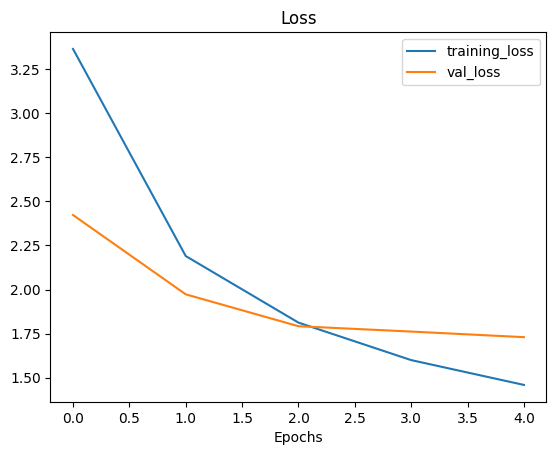

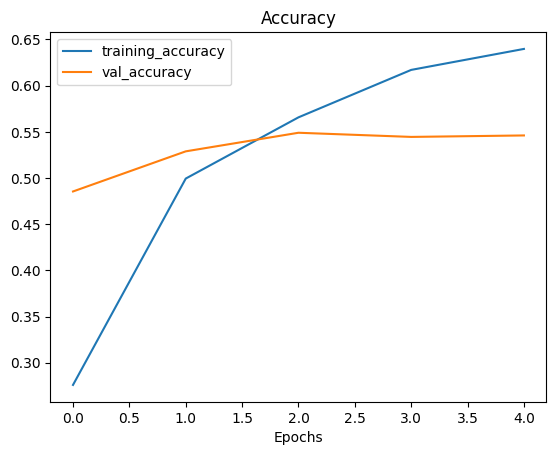

In [13]:
plot_loss_curves(history_all_class_10_percent)

> **Question:** What do these curves suggest? Hint: Ideally, the two curves should be very similar to each other if not...